##### **Analyse Sentinel-2 data**

See the [data getter](get_sentinel_data.ipynb) for further details on how the data was downloaded, which includes a degree of pre-processing.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm

import plotly.express as px

from dython.nominal import associations

import intake

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
catalog = intake.open_catalog(Path('../catalog.yml'))
source = getattr(catalog, 'treesat')
gdf = source.read()[source.metadata['usecols']]
gdf.crs = 25832
gdf = gdf.to_crs(epsg=4326)
target = source.metadata['categories']['multi']

These are the bands that have been downloaded. It follows the same order as the data structure.

In [3]:
tci_bands = dict(zip(['TCI_R', 'TCI_G', 'TCI_B'], ['red', 'green', 'blue']))
bgr_bands = dict(zip(['B2', 'B3', 'B4'], ['#00ffb5', '#c3ff00', '#ff0000']))
nir_bands = dict(zip(['B5', 'B6', 'B7', 'B8', 'B8A'],px.colors.cyclical.Twilight[:5]))
swir_bands = dict(zip(['B11', 'B12'], px.colors.qualitative.Plotly[:2]))
all_bands = list(bgr_bands) + list(nir_bands) + list(swir_bands) + list(tci_bands)

There are 7 years of monthly average starting April 2017, ending March 2024 (inclusive).

In [4]:
parent_directory = Path('seasonal_median')
filepaths = sorted(list(parent_directory.glob('treesat_*.npy')))

Evaluate the masked values (masked as zeros). The goal is to replace the zeros with their respective band average to avoid scaling issues as the band values can have different ranges.

The band average is only representative if there is a sufficient amount of non-zeros. 

In [5]:
band_zeros = {k: [] for k in all_bands}

season_zeros = {k: [] for k in [3, 6, 9, 12]}

band_samples = {k: [] for k in all_bands}

for filepath in tqdm(filepaths): 
    with open(filepath, 'rb') as f:
        raw_data = np.load(filepath)

    # Convert to unstructured data for processing monthly 0s
    data = raw_data.view((float, len(raw_data.dtype.names)))
    month = int(filepath.stem.split('_')[1][-2:])
    
    season_zeros[month].append((data == 0).sum()/data.size)
    
    # Calculate band zeros.
    for band in all_bands:
        zero_fraction = (raw_data[band] == 0).sum()/raw_data[band].size
        band_zeros[band].append(zero_fraction)

        random_sample = np.random.choice(raw_data[band].flatten(), size=500)
        band_samples[band].extend(random_sample)
    

  0%|          | 0/28 [00:00<?, ?it/s]

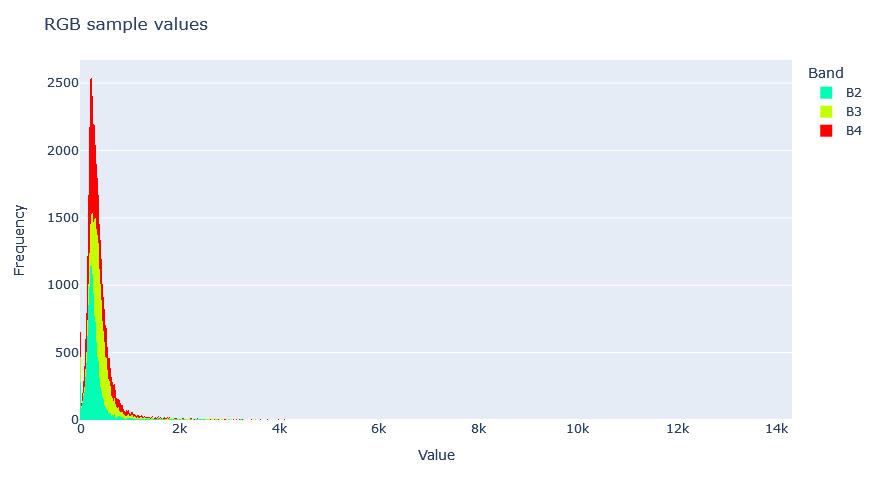

In [6]:
fig = px.histogram(
    {k: band_samples[k] for k in bgr_bands}, 
    color_discrete_map=bgr_bands)

fig.update_layout(
    xaxis_title='Value', yaxis_title="Frequency", title='RGB sample values',
    legend_title_text='Band', height=500
)

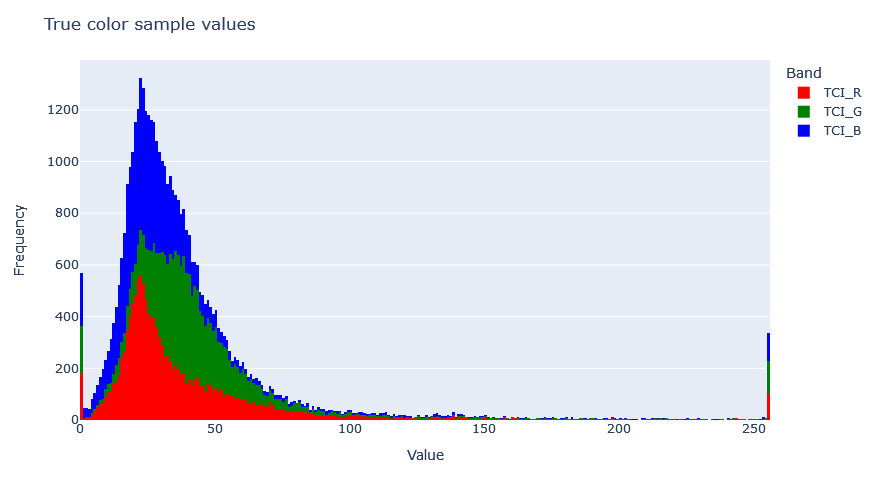

In [7]:
fig = px.histogram({k: band_samples[k] for k in tci_bands}, 
             color_discrete_map=tci_bands)
fig.update_layout(
    xaxis_title='Value', yaxis_title="Frequency", title='True color sample values',
    legend_title_text='Band', height=500
)

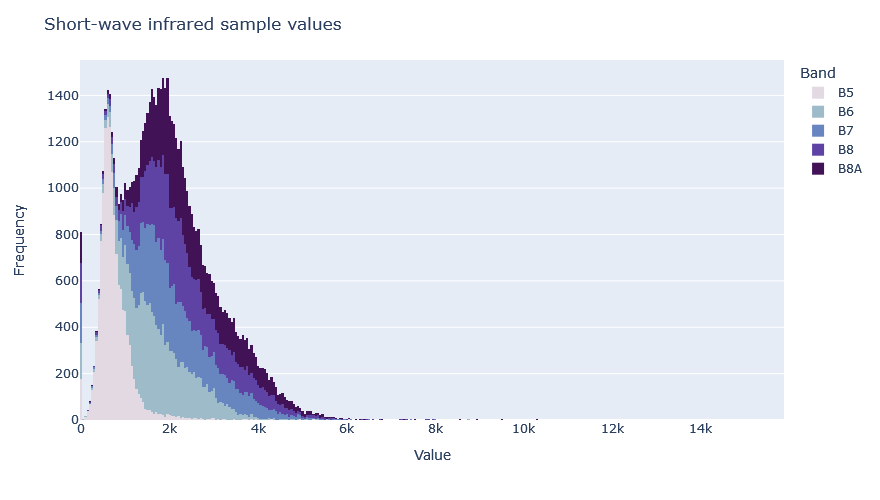

In [8]:
fig = px.histogram({k: band_samples[k] for k in nir_bands}, 
             color_discrete_map=nir_bands)
fig.update_layout(
    xaxis_title='Value', yaxis_title="Frequency", 
    title='Short-wave infrared sample values',
    legend_title_text='Band', height=500
)

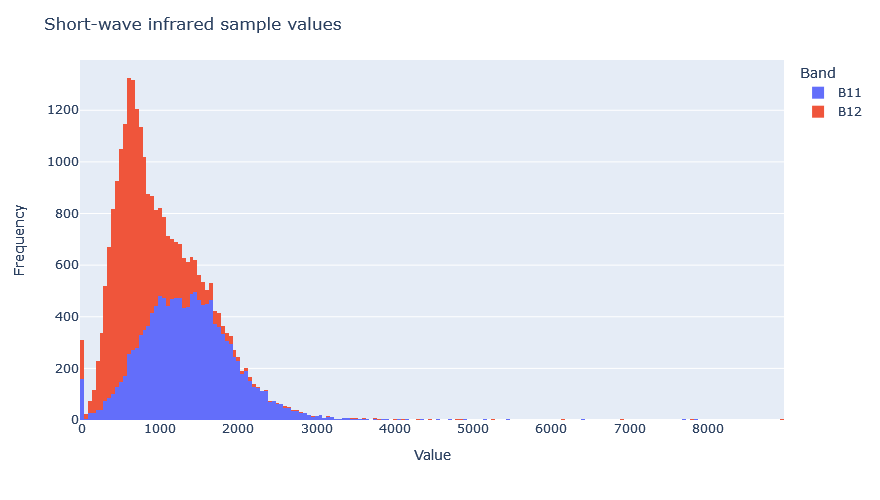

In [9]:
fig = px.histogram({k: band_samples[k] for k in swir_bands}, 
             color_discrete_map=swir_bands)
fig.update_layout(
    xaxis_title='Value', yaxis_title="Frequency", 
    title='Short-wave infrared sample values',
    legend_title_text='Band', height=500
)

The bands display positively skewed distributions.

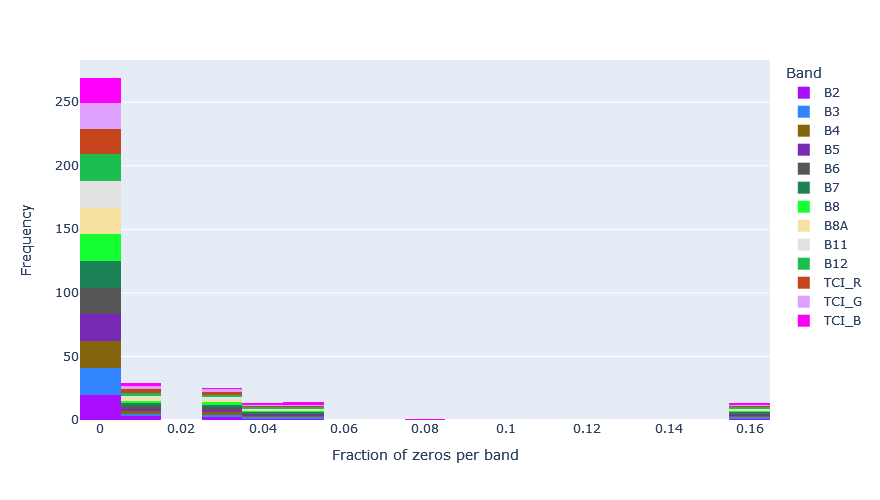

In [10]:
fig = px.histogram(band_zeros, color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(
    xaxis_title="Fraction of zeros per band", yaxis_title="Frequency",
    legend_title_text='Band', height=500
)

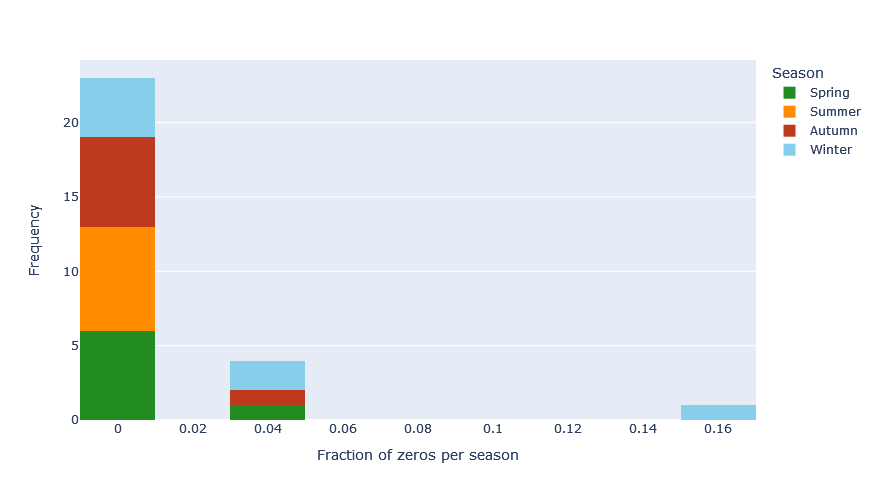

In [11]:
season_map = {3: 'Spring', 6: 'Summer', 9: 'Autumn', 12: 'Winter'}
color_map = {'Spring': 'forestgreen', 'Summer': 'darkorange', 
             'Autumn': '#bd3a1e', 'Winter': 'skyblue'}
zeros_mapped = dict((season_map[name], val) for name, val in season_zeros.items())

fig = px.histogram(
    zeros_mapped,
    color_discrete_map=color_map
)

fig.update_layout(
    xaxis_title="Fraction of zeros per season", yaxis_title="Frequency",
    legend_title_text='Season', height=500
)

As seen above, masked values do not present a significant problem.

Similar to the previous iteration, but this time replace the masked values with averages and save the processed data.

**Note: as an awareness check, you must create directory processed_data first. This will contain the same data size. Original data is not affected.** 

In [12]:
processed_filepaths = []
for filepath in tqdm(filepaths):
    save_path = Path(filepath.parent).joinpath(f'processed_{filepath.name}')
    processed_filepaths.append(save_path)
    
    if save_path.is_file():
        continue
        
    with open(filepath, 'rb') as f:
        raw_data = np.load(filepath)

    for band in selected_bands:
        zero_fraction = (raw_data[band] == 0).sum()/raw_data[band].size
        
        if zero_fraction < 0.6:
            raw_data[band] = np.where(
                raw_data[band] > 0, raw_data[band], raw_data[band][raw_data[band] > 0].mean())
        else:
            raise ValueError(f'Too many zeros: {zero_fraction:.2f} of data. '
                             'Modify the condition or employ a different strategy.')
            
    data = raw_data.view((float, len(raw_data.dtype.names)))
    with open(save_path, 'wb') as f:
        np.save(f, data)

  0%|          | 0/28 [00:00<?, ?it/s]

Get a few samples and display a few images as an animation.

In [13]:
n_samples = 15
gdf_samples = gdf.sample(n_samples, random_state=234)

def get_sample_images(filepaths, gdf_samples):
    image_arrays = dict(true=[], false=[])
    for filepath in tqdm(filepaths):
        with open(filepath, 'rb') as f:
            data = np.load(f)
        rgb = data[gdf_samples.index.tolist(),...]
        rgb = rgb[...,[8,4,3]]
        rgb = 250/0.3*np.clip(rgb/10000, 0.0, 0.3)
        image_arrays['false'].append(rgb)
    
        image_arrays['true'].append(data[gdf_samples.index.tolist(),...,-3:])
    return image_arrays
        
monthly_image_samples = get_sample_images(processed_filepaths, gdf_samples)

  0%|          | 0/28 [00:00<?, ?it/s]

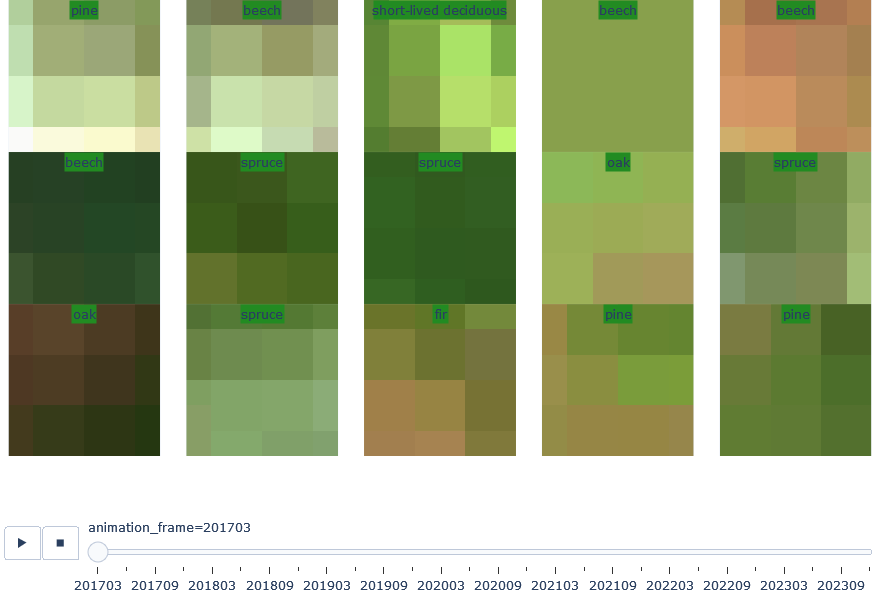

In [14]:
def visualise_grid(image_arrays, date_labels, samples, color_spectrum='false'):
    
    fig = px.imshow(np.array(image_arrays[color_spectrum]), facet_col=1, facet_col_wrap=5,
                    animation_frame=0, height=600,
                    facet_col_spacing=0.01, facet_row_spacing=0.0001)
    
    for date_label, step in zip(date_labels, fig.layout.sliders[0].steps):
        step.label = date_label
        
    for ann in fig.layout.annotations:
        ann.text = samples.iloc[int(ann.text.split('=')[1])][target]
        ann.bgcolor = 'forestgreen'
        ann.yanchor = 'top'
    
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.update_layout(margin={'t':0,'l':0,'b':0,'r':0})
    return fig

date_labels = [f.stem.split('_')[-1] for f in processed_filepaths]
visualise_grid(monthly_image_samples, date_labels, gdf_samples)

Another approach is to combine seasons across all years available. Here, they are combined by taking the mean and saved for further processing.

In [15]:
seasonal_paths = []

for season_key in tqdm(season_map.keys()):
    season_paths = parent_directory.glob(f'processed*{season_key}.npy')
    save_path = parent_directory.joinpath(f'{season_map[season_key]}.npy')
    seasonal_paths.append(save_path)
    
    if save_path.is_file():
        continue
        
    season_data = []
    for filepath in season_paths:
        
        with open(filepath, 'rb') as f:
            season_data.append(np.load(filepath))
    
    with open(save_path, 'wb') as f:
        np.save(f, np.mean(season_data, axis=0))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

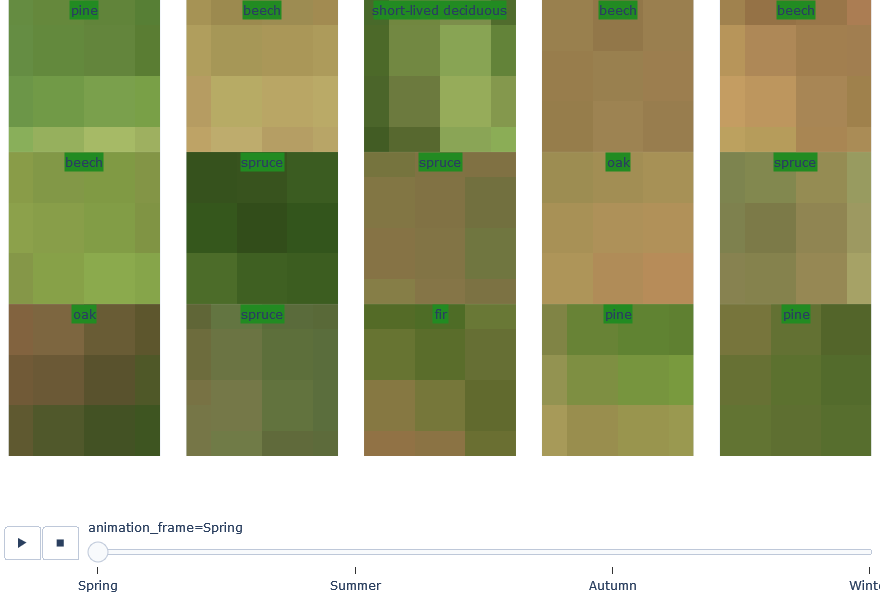

In [16]:
seasonal_image_samples = get_sample_images(seasonal_paths, gdf_samples)

visualise_grid(seasonal_image_samples, season_map.values(), gdf_samples)

Perform a correlation analysis. In order to do this, either flatten the images into a 2d array or take the means of the 36 pixels.

In [49]:
def calculate_corrs(seasonal_paths, all_bands, target_column, method_means=False):
    corrs = []
    for filepath in tqdm(seasonal_paths):
        with open(filepath, 'rb') as f:
            data = np.load(filepath)
            if method_means:
                df = pd.DataFrame(np.mean(data, axis=(1, 2)), columns=all_bands)
                df['target'] = target_column.astype('category').values
            else:
                df = pd.DataFrame(data.reshape(-1, len(all_bands)), columns=all_bands)
                df['target'] = target_column.astype('category').repeat(36).values
            
            corrs.append(associations(df, compute_only=True)['corr'].round(1))
    return corrs

For further details: http://shakedzy.xyz/dython/

  0%|          | 0/4 [00:00<?, ?it/s]

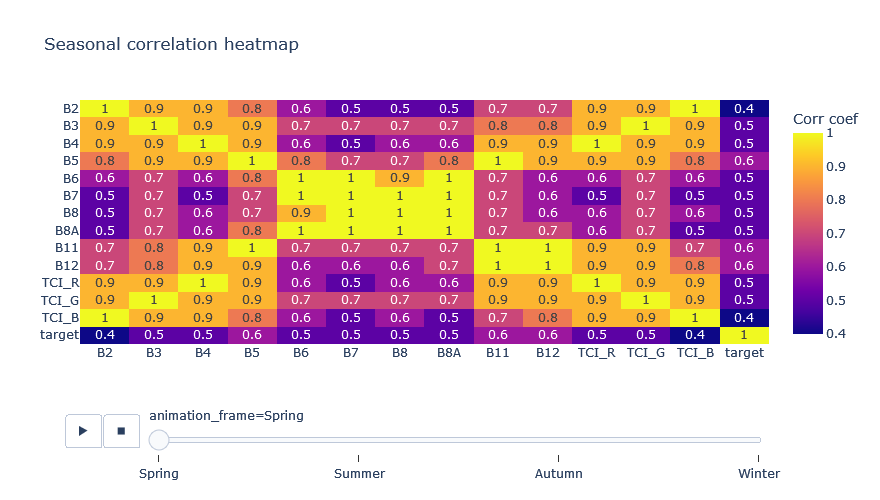

In [52]:
corrs = calculate_corrs(seasonal_paths, all_bands, gdf[target], method_means=False)
fig = px.imshow(
    np.array(corrs),
    animation_frame=0,
    labels=dict(color="Corr coef"),
    x=corrs[0].index,
    y=corrs[0].columns,
    title='Seasonal correlation heatmap',
    text_auto=True, aspect='auto', zmin=None, height=500
)
for season, step in zip([s.stem for s in seasonal_paths], fig.layout.sliders[0].steps):
    step.label = season

fig